In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from model_em import fbsde
from model_em import BSDEsolverEm 
from model_mil import BSDEsolverMil

#defining our equation
dim_x, dim_y, dim_d, dim_h, num_h, N, itr, batch_size = 100, 1, 1, 24, 3, 50, 3000, 256#batch size is number of paths used in each iteration

x_0, T = torch.ones(dim_x), 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
A = torch.rand(dim_x,device=device)
B = torch.rand(dim_x,device=device)
S = torch.rand(dim_x,device=device)


def b(t, x, y):
    return (A*(B-x)).reshape(batch_size, dim_x)


def sigma(t, x):
    return (S*torch.sqrt(torch.abs(x))).reshape(batch_size, dim_x, dim_d)


def f(t, x, y, z):
    return -y*torch.max(x, 1)[0].reshape(batch_size, dim_y)


def g(x):
    return torch.ones(batch_size, dim_y,device=device)


equation = fbsde(x_0, b, sigma, f, g, T,dim_x,dim_y,dim_d)

samples = 1

In [2]:
'''for i in range(samples):
    bsde_solver_em = BSDEsolverEm(equation, dim_h, num_h) 
    bsde_solver_em.train(batch_size, N, itr, log=True, test_num= i)'''

'for i in range(samples):\n    bsde_solver_em = BSDEsolverEm(equation, dim_h, num_h) \n    bsde_solver_em.train(batch_size, N, itr, log=True, test_num= i)'

y0 error:  0.0
network loss:  0.00102737988345325


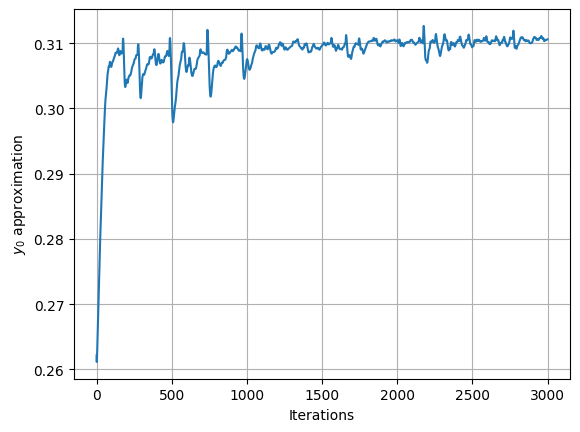

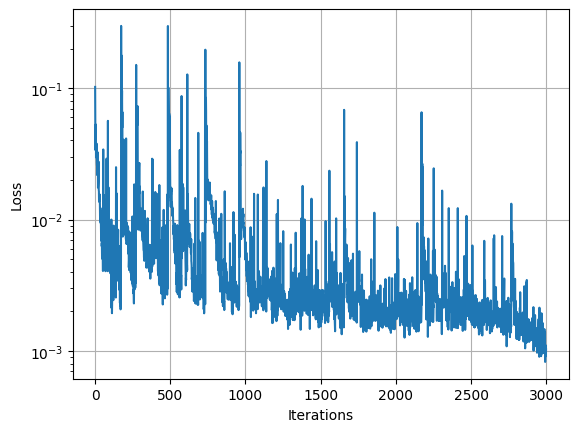

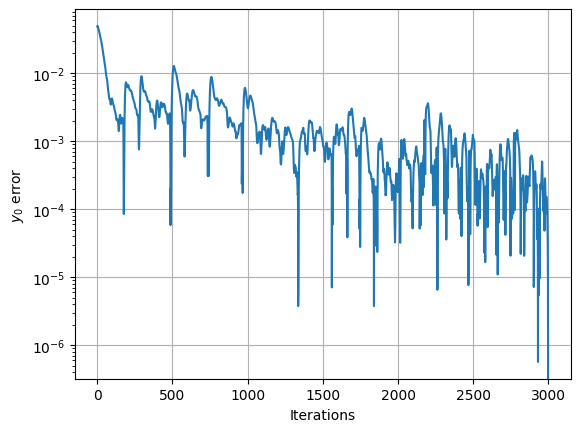

In [3]:
mean_loss = np.zeros(itr)
mean_y0 = np.zeros(itr)
loss_std_mat = []
y0_std_mat = []

for i in range(samples):
    loss_data = np.load(f'loss_data_EM{i}.npy')
    y0_data = np.load(f'y0_data_EM{i}.npy')
    mean_loss += loss_data/samples
    mean_y0 += y0_data/samples
      #append all to matrix
    loss_std_mat.append(loss_data)

y0 = mean_y0[-1]
mean_y0_error = np.zeros(itr)
for i in range(samples):
    y0_data = np.load(f'y0_data_EM{i}.npy')
    y0_error = np.abs(y0 - y0_data)
    mean_y0_error += y0_error/samples
    y0_std_mat.append(y0_error)

#create std vector
loss_std = np.zeros(itr)
y0_std = np.zeros(itr)
for i in range(itr):
    loss_std[i] = np.std([loss_std_mat[j][i] for j in range(samples)])
    y0_std[i] = np.std([y0_std_mat[j][i] for j in range(samples)])


plt.figure()
plt.plot(mean_y0)
plt.fill_between(range(itr), mean_y0 - y0_std, mean_y0 + y0_std, alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('$y_0$ approximation')
plt.grid()
#plt.yscale('log')

plt.figure()
plt.plot(mean_loss)
#plt.fill_between(range(itr), mean_loss - (loss_std), mean_loss + (loss_std), alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()

plt.figure()
plt.plot(mean_y0_error)
#plt.fill_between(range(itr), mean_y0_error - y0_std, mean_y0_error + y0_std, alpha=0.2)
plt.xlabel('Iterations')
plt.ylabel('$y_0$ error')
plt.yscale('log')
print("y0 error: ", mean_y0_error[-1])
plt.grid()

print("network loss: ", mean_loss[-1])

In [4]:
#training full milstein model
for i in range(samples, samples+10):
    bsde_solver_mil = BSDEsolverMil(equation, dim_h, num_h)
    bsde_solver_mil.train(batch_size, N, itr, log=True, test_num=i)
    print( (i+1)*10, '%' )

RuntimeError: shape '[-1, 100]' is invalid for input of size 256